In [10]:
# 数据接口 
import akshare as ak
import baostock as bs
import tushare as ts

# 基础模块
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

# 回测框架
import backtrader as bt

# 基础函数
import utilsJ

# 策略

In [11]:
class Strategy_wave1(bt.Strategy):
    
    params = (
        ('printlog', False),
        ('smoothing_period', 5),
        ('stack_len', 3),
    )
    
    
    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s: %s' % (dt.isoformat(), txt))
            #with open('log.txt', 'a') as file:
                #file.write('%s: %s \n' % (dt.isoformat(), txt))
        
    
    def __init__(self):
        
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.buyprice = None
        self.sellprice = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
                    self.datas[0], period=self.params.smoothing_period)
        
        # Add a singal stack
        self.stack = [0] * self.params.stack_len
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                
                self.log('BUY EXECUTED, Price: %.2f, Lot:%i, Cash: %i, Value: %i' %
                         (order.executed.price,
                          order.executed.size,
                          self.broker.get_cash(),
                          self.broker.get_value()))
                self.buyprice = order.executed.price

            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Lot:%i, Cash: %i, Value: %i' %
                        (order.executed.price,
                          -order.executed.size,
                          self.broker.get_cash(),
                          self.broker.get_value()))
                self.sellprice = order.executed.price

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        #self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
        
        
    def next(self):
        
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        #if self.order:
        #    return
        
        for i in range(1, self.params.stack_len+1):
            self.stack[-i] = 1 if self.sma[-i+1] - self.sma[-i] > 0 else -1
            
        # Wave Buy Signal
        if self.stack[-1] == 1 and sum(self.stack) in [-1 * (self.params.stack_len - 2), -1 * (self.params.stack_len - 3)]:
            if self.buyprice is None:
                self.log('BUY CREATE, Price: %.2f, Lots: %i, Current Position: %i' % (self.dataclose[0], 
                                                                                      100, self.getposition(self.data).size))
                self.buy(size = 100)            
            elif self.dataclose > self.buyprice:
                self.log('BUY CREATE, Price: %.2f, Lots: %i, Current Position: %i' % (self.dataclose[0], 
                                                                                                 100, self.getposition(self.data).size))
                self.buy(size = 100)

        # Wave Sell Singal
        elif self.stack[-1] == -1 and sum(self.stack) in [1 * (self.params.stack_len - 2), 1 * (self.params.stack_len - 3)]:
                if self.getposition(self.data).size > 0:
                    self.log('SELL CREATE (Close), Price: %.2f, Lots: %i' % (self.dataclose[0], 
                                                                                            self.getposition(self.data).size))
                    self.close()
                    
        # Keep track of the created order to avoid a 2nd order
        #self.order = self.sell(size = self.getposition(data).size - opt_position)                   

# 思路

中钢天源(002057)过去一年(2021/09/22至2022/09/21)的股价收盘价波动为下图蓝线。

将其取7日平均之后可得橘线。

橘线可大致看成为该股票的波形。

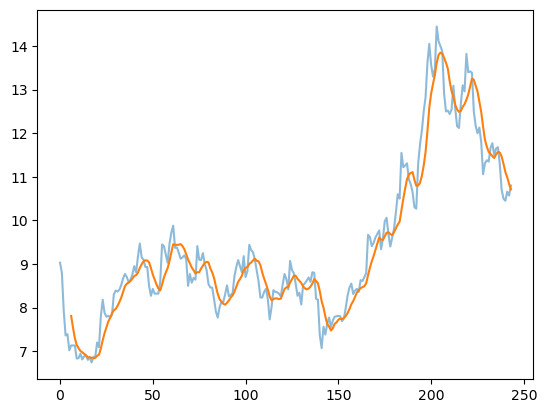

In [10]:
%matplotlib inline

stock_index = '002057.SZ'
df = utilsJ.stock_tushare('74f1379591c9d810854fa5891fffcacaba514b82bf17ec2e239025b6', 
                          stock_index)

plt.plot(range(len(df)), df.close, alpha = 0.5)
plt.plot(range(len(df)), df.close.rolling(7).mean())

对橘线进行求一阶导，可得以下趋势，其中每一次穿越 $y=0$ 表示波浪改变方向。

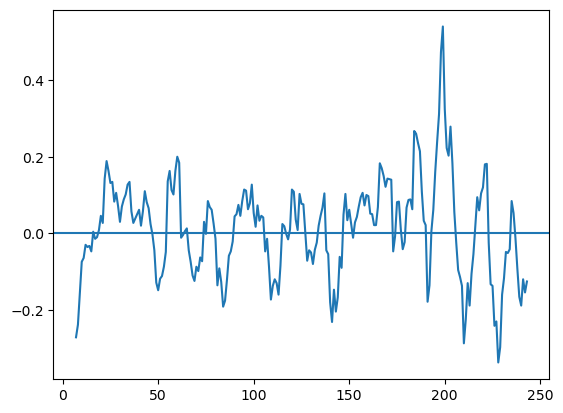

In [5]:
%matplotlib inline
plt.plot(range(1, len(df)), np.diff(df.close.rolling(7).mean()))
plt.axhline(0)

### 策略细节

参数：
1. 日线平均周期，默认为5。
2. 信号栈长短，默认为3.

步骤：
1. 计算当日均线与昨日均线之差。如差值大于0，则向信号栈末尾添加‘上升’信号(1)；若差值小于等于0，则向信号栈末尾添加'下降'信号(-1)。
2. 如果信号栈呈现特定的排列，则释放买入/卖出信号。
3. 每次买入100股，每次全部卖出。

例如：
信号栈长短为3。

连续两天下跌，今日上涨，则信号栈为[-1, -1, 1]，可能是从调整浪变为上升浪，则进行买入；

连续两天上涨，今日下跌，则信号栈为[1, 1, -1]，可能是从上升浪变为调整浪，则进行卖出。

# 回测 中钢天源 002057 2021/09/22 - 2022/09/21

In [33]:
if __name__ ==  '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    strats = cerebro.addstrategy(Strategy_wave1,printlog=False, smoothing_period=7) 

    s_date = datetime.datetime.now() - datetime.timedelta(days = 365)
    e_date = datetime.datetime.now()

    # Create stock Data Feed
    stock_index = '002057.SZ'
    df = utilsJ.stock_tushare('74f1379591c9d810854fa5891fffcacaba514b82bf17ec2e239025b6', 
                        stock_index, s_date, e_date)
    data = bt.feeds.PandasData(dataname=df,fromdate=s_date,todate=e_date)

    # Add the index Data Feed to Cerebo
    cerebro.adddata(data)
    
    # Set cash inside the strategy
    cerebro.broker = bt.brokers.BackBroker(coc=True)   
    cerebro.broker.setcash(2000)

    # Set commission
    #cerebro.broker.setcommission()

    # Print out the starting conditions
    start_value = cerebro.broker.getvalue()
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    final_value = cerebro.broker.getvalue()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    print('Net Profit: %.2f%%' % ((final_value - start_value) / start_value * 100))

Starting Portfolio Value: 2000.00
2021-10-21: BUY CREATE, Price: 6.86, Lots: 100, Current Position: 0
2021-10-22: BUY EXECUTED, Price: 6.86, Lot:100, Cash: 1314, Value: 1988
2021-10-26: BUY CREATE, Price: 6.87, Lots: 100, Current Position: 100
2021-10-27: BUY EXECUTED, Price: 6.87, Lot:100, Cash: 627, Value: 2067
2021-12-03: SELL CREATE (Close), Price: 8.93, Lots: 200
2021-12-06: SELL EXECUTED, Price: 8.93, Lot:200, Cash: 2413, Value: 2413
2021-12-06: OPERATION PROFIT, GROSS 413.00, NET 413.00
2021-12-15: BUY CREATE, Price: 9.45, Lots: 100, Current Position: 0
2021-12-16: BUY EXECUTED, Price: 9.45, Lot:100, Cash: 1468, Value: 2409
2021-12-24: SELL CREATE (Close), Price: 9.37, Lots: 100
2021-12-27: SELL EXECUTED, Price: 9.37, Lot:100, Cash: 2405, Value: 2405
2021-12-27: OPERATION PROFIT, GROSS -8.00, NET -8.00
2022-06-17: BUY CREATE, Price: 9.98, Lots: 100, Current Position: 0
2022-06-20: BUY EXECUTED, Price: 9.98, Lot:100, Cash: 1407, Value: 2413
2022-06-22: SELL CREATE (Close), Price:

<IPython.core.display.Javascript object>


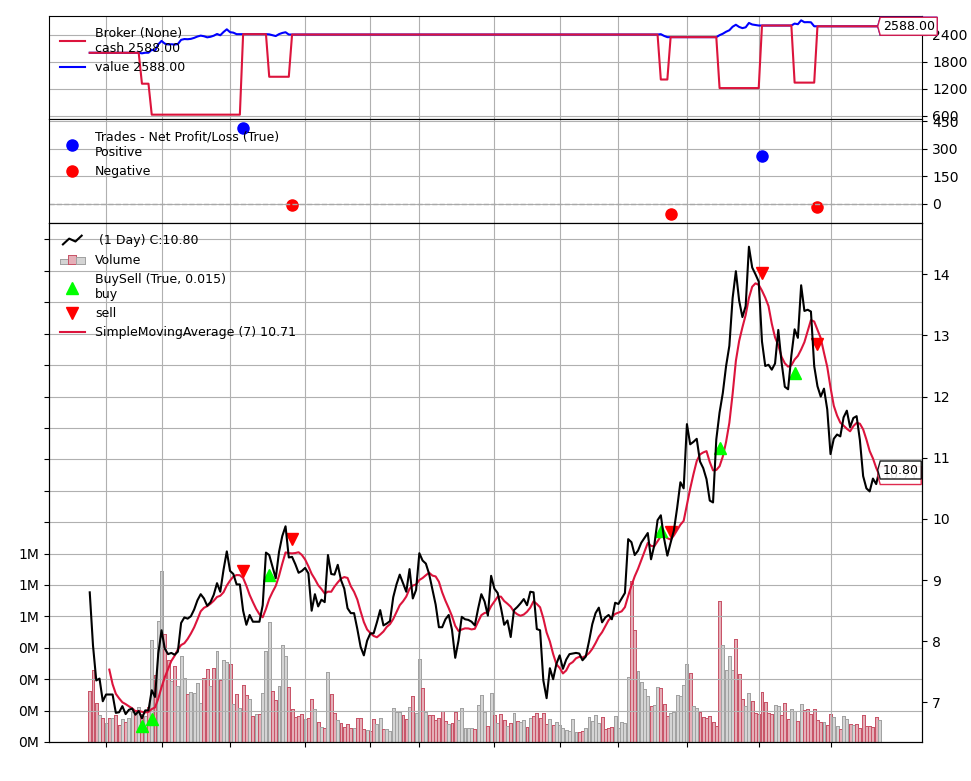

[[<Figure size 640x480 with 4 Axes>]]

In [35]:
%matplotlib notebook
cerebro.plot()

# 全市场回测

In [49]:
profit_list = []

pro = ts.pro_api('74f1379591c9d810854fa5891fffcacaba514b82bf17ec2e239025b6')
stock_list = pro.stock_basic(exchange='', list_status='L', fields='ts_code,symbol,name,area,industry,list_date').ts_code.tolist()
for stock_c in stock_list[4301:4900]:
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    strats = cerebro.addstrategy(Strategy_wave1,printlog=False, smoothing_period=7) 

    s_date = datetime.datetime.now() - datetime.timedelta(days = 365)
    e_date = datetime.datetime.now()

    # Create stock Data Feed
    df = utilsJ.stock_tushare('74f1379591c9d810854fa5891fffcacaba514b82bf17ec2e239025b6', 
                        stock_c, s_date, e_date)
    data = bt.feeds.PandasData(dataname=df,fromdate=s_date,todate=e_date)

    # Add the index Data Feed to Cerebo
    cerebro.adddata(data)
    
    # Set cash inside the strategy
    cerebro.broker = bt.brokers.BackBroker(coc=True)   
    cerebro.broker.setcash(10000)

    # Set commission
    #cerebro.broker.setcommission()

    # Print out the starting conditions
    start_value = cerebro.broker.getvalue()
    #print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    final_value = cerebro.broker.getvalue()
    #print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    net_profit = (final_value - start_value) / start_value * 100
    profit_list.append((stock_c, net_profit))
    time.sleep(0.5)

IndexError: array assignment index out of range

In [50]:
sorted(profit_list, key=lambda x: x[1], reverse=True)

[('688022.SH', 26.52),
 ('605333.SH', 25.45),
 ('688017.SH', 19.29),
 ('688027.SH', 18.68),
 ('605289.SH', 18.43),
 ('688030.SH', 15.1),
 ('688020.SH', 11.44),
 ('605286.SH', 10.97),
 ('688005.SH', 9.049999999999981),
 ('605377.SH', 8.12),
 ('605555.SH', 8.07),
 ('605259.SH', 7.739999999999999),
 ('605266.SH', 6.4399999999999995),
 ('688025.SH', 5.07),
 ('688006.SH', 4.14),
 ('605336.SH', 3.7199999999999998),
 ('605277.SH', 3.15),
 ('688018.SH', 2.7),
 ('605255.SH', 1.63),
 ('605287.SH', 1.58),
 ('688015.SH', 0.7000000000000001),
 ('605288.SH', 0.58),
 ('605298.SH', 0.52),
 ('605368.SH', 0.47000000000000003),
 ('605399.SH', 0.27999999999999997),
 ('605199.SH', 0.22999999999999998),
 ('605299.SH', 0.09),
 ('605566.SH', 0.02),
 ('605303.SH', 0.01),
 ('605499.SH', 0.0),
 ('688012.SH', 0.0),
 ('688016.SH', 0.0),
 ('688019.SH', 0.0),
 ('688023.SH', 0.0),
 ('688032.SH', 0.0),
 ('605339.SH', -0.11),
 ('688009.SH', -0.13999999999999999),
 ('605580.SH', -0.26),
 ('605500.SH', -0.27),
 ('605305.